## NonUniform methods

In [247]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from scipy import stats
from scipy import optimize
from scipy import integrate
from scipy import misc

from tqdm.notebook import tqdm
import time

In [282]:
def array_to_f(x,x_,y_) :
    return y_[min(np.searchsorted(x_,x),len(x_)-1)]

def array_to_inverse_f(y,x_,y_) :
    return x_[min(np.searchsorted(y_,y),len(y_)-1)]

def f_to_array(f,x_,) :
    return np.array([f(x) for x in x_])

def bid1_f(v,method_out) :
    return method_out['tstar']*np.searchsorted(method_out['values1_'],v)/(method_out['N']+1)

def bid2_f(v,method_out) :
    return method_out['tstar']*np.searchsorted(method_out['values2_'],v)/(method_out['N']+1)

In [283]:
def display2(out) :
    plt.figure(figsize=(15,4.5))
    plt.suptitle(r"Coallition $k_1={}$ vs Individuals $k_2={}$".format(out['k1'],out['k2']))
    v_ = np.linspace(0,1,1001)
    
    plt.subplot(131)
    plt.plot(np.linspace(0,out['tstar'],out['N']+2),out['delta1_star_'],'b',label=r'$\delta_1^*$')
    plt.plot(np.linspace(0,out['tstar'],out['N']+2),out['delta2_star_'],'r',label=r'$\delta_2^*$')
    plt.axhline(out['l1_star'],color='b',linestyle='--')
    plt.axhline(1/out['tstar'],color='gray',linestyle='--')
    plt.axhline(out['l2_star'],color='r',linestyle='--')
    #plt.ylim((min(out['l2_star'],out['l1_star'])-0.1,max(out['l2_star'],out['l1_star'])+0.1))
    
    plt.axvline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    
    plt.title(r"Approximated functions : $\delta_i^*(b) = \lambda_i^*(b)/b$")
    plt.legend()
    
    
    plt.subplot(132)
    b_ = np.linspace(0,out['tstar'],out['N']+2)
    plt.plot(b_,out['values1_'],'b',label=r'$\lambda_1$')
    plt.plot(b_,out['values2_'],'r',label=r'$\lambda_2$')
    plt.plot(b_,out['l1']*b_,'b--')
    plt.plot(b_,out['l2']*b_,'r--')
    
    plt.title(r"Value functions $\lambda_i$")
    plt.legend()
    plt.xlim((0,out['tstar']))
    plt.grid(True, which='both')
    
    
    plt.subplot(133)
    plt.plot(v_,[bid1_f(v,out) for v in v_],'b',label=r"$\phi_1$")
    plt.plot(v_,[bid2_f(v,out) for v in v_],'r',label=r"$\phi_2$")
    plt.plot(v_,1/out['l1']*v_,'b--')
    plt.plot(v_,1/out['l2']*v_,'r--')
    plt.axhline(out['tstar'],color='gray',linestyle='--')
    
    plt.title(r"Bid functions $\phi_i$")
    plt.legend()
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.grid(True, which='both')
    
    plt.show()

### Scenario : Coalition of $k_1$ bidders drawing their individual values from $F_1$ against $k_2$ individuals drawing their values from $F_2$

We assume $F_1,F_2$ has support $[0,1]$.


The differential system written in terms of $\lambda_i^* = F_i \circ \lambda_i$  is the following:

$$ k_2 (F_1^{-1}(\lambda^*_1(t))-t) (\lambda^*_2)'(t) = \lambda^*_2(t) $$
$$ (F_2^{-1}(\lambda^*_2(t))-t) \left[ k_1 (\lambda^{*}_1)'(t)\lambda^*_2(t) + (k_2-1) (\lambda^{*}_2)'(t)\lambda^*_1(t) \right] = \lambda^*_1(t)\lambda^*_2(t)$$

$$ \lambda_i^*(0) = 0, \lambda_i^*(t_*)=1 $$

The actual system solved is the one written in terms of $\delta^*_i(t) = \frac{\lambda^*_i(t)}{t}$ as recommended in Marshall1994 for more stability.

In [171]:
def scenario1_shoot(tstar,k1,k2,RV_1,RV_2,N=10_000,correct=True) :
    delta1_star_ = np.zeros(N+2)
    delta2_star_ = np.zeros(N+2)
    
    l1_star = RV_1.pdf(0)*(1+1/k2)
    l2_star = RV_2.pdf(0)*(1+1/(k1+k2-1))
    
    l1 = (1+1/k2) #WRONG if f(0)=0
    l2 = (1+1/(k1+k2-1)) #WRONG if f(0)=0
    
    
    output = {}
    output['tstar'] = tstar
    output['N']=N
    output['breakpoint'] = 0
    output['l1_star'] = l1_star
    output['l2_star'] = l2_star
    output['l1'] = l1
    output['l2'] = l2   
    output['k1'] = k1
    output['k2'] = k2  
    
    delta1_star_[N+1] = 1/tstar #warning: if the rvs are not supported by [0,1]
    delta2_star_[N+1] = 1/tstar 
    
    a0 = 0; a1 = 0; b0 = 0; b1 = 0
    
    for j in np.arange(N+1,0,-1) : #j=N+1,...,1
        tj = tstar*j/(N+1)

        a0 = delta1_star_[j]
        b0 = delta2_star_[j]
        
        b1 = b0*(1/(k2*(RV_1.ppf(max(min(a0*tj,1),0))-tj))-1/tj)
        a1 = a0/tj * ( -1+ (1/(k1*b0))*( (tj*b0)/(RV_2.ppf(max(min(b0*tj,1),0))-tj)-(k2-1)*(b1*tj+b0) ) 
        
        tjm1 = tstar*(j-1)/(N+1)
        
        delta1_star_[j-1] = a0+(tjm1-tj)*a1
        delta2_star_[j-1] = b0+(tjm1-tj)*b1
        
#        if(delta1_star_[j-1] < 0 or delta1_star_[j-1]>1/tjm1 or delta2_star_[j-1] < 0 or delta2_star_[j-1]>1/tjm1) :
#            print("delta1_star or delta2_star is out of range for j=",j-1)
        
        if(output['breakpoint'] == 0 and ((delta1_star_[j-1]-l1_star)**2+(delta2_star_[j-1]-l2_star)**2 > ((delta1_star_[j]-l1_star)**2+(delta2_star_[j]-l2_star)**2))) :
            output['breakpoint'] = j
            if(correct) :
                break
                
    output['eps_star'] = np.sqrt(((delta1_star_[output['breakpoint']]-l1_star)**2+(delta2_star_[output['breakpoint']]-l2_star)**2))
    #output['precision'] = np.min(((delta1_-l1_star)**2+(delta2_-l2_star)**2))
    if(correct) :
        ind = output['breakpoint']
        delta1_star_[:ind+1] = np.linspace(l1_star,delta1_star_[ind],ind+1)
        delta2_star_[:ind+1] = np.linspace(l2_star,delta2_star_[ind],ind+1)
        
    output['delta1_star_']=delta1_star_
    output['delta2_star_']=delta2_star_
    output['values1_']=RV_1.ppf(np.linspace(0,tstar,N+2)*delta1_star_)
    output['values2_']=RV_2.ppf(np.linspace(0,tstar,N+2)*delta2_star_)
    return output

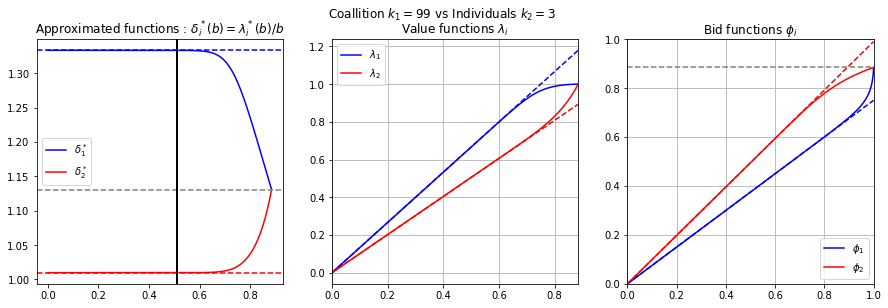

-1.2457412915893986
1.9804256714315367
-1.245666075990596
1.9769782094040793


In [306]:
k1 = 99; k2=3;
tstar = 0.8843460266020277
out = scenario1_shoot(tstar,k1,k2,stats.uniform(),stats.uniform())
display(out)
tj = tstar

a0 = 1/tstar
b0 = 1/tstar
        
b1 = b0*(1/(k2*(a0*tj-tj))-1/tj)
a1 = a0/tj * ( -1+ (1/(k1*b0))*( (tj*b0)/(b0*tj-tj)-(k2-1)*(b1*tj+b0) ))
              
print(a1)
print(b1)

a0 = a0-1/10_001*a1
b0 = b0-1/10_001*b1

b1 = b0*(1/(k2*(a0*tj-tj))-1/tj)
a1 = a0/tj * ( -1+ (1/(k1*b0))*( (tj*b0)/(b0*tj-tj)-(k2-1)*(b1*tj+b0) ))

print(a1)
print(b1)

In [292]:
print(out['tstar'])

0.8843460266020277


## Previous case $F_1=F_2=\text{Unif}[0,1]$

<font color=green>$\rightarrow$ better results</font>

Nb of eval : 2
eps_star : 0.0
tstar : 0.8


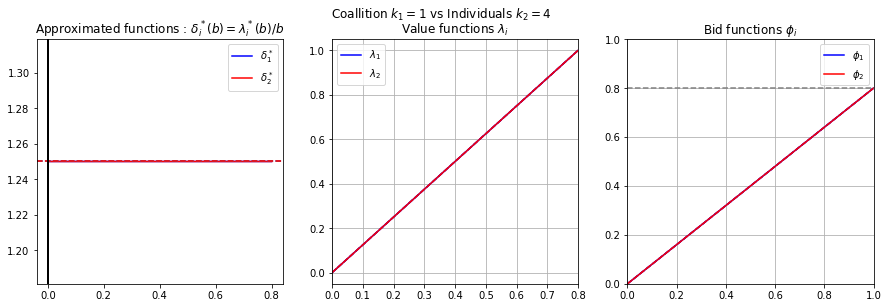

Nb of eval : 27
eps_star : 2.3267144644222278e-06
tstar : 0.783241681138307


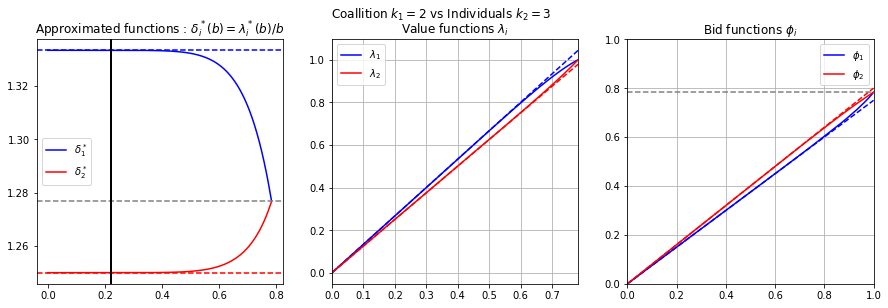

Nb of eval : 36
eps_star : 9.856146961981655e-06
tstar : 0.7416970532668846


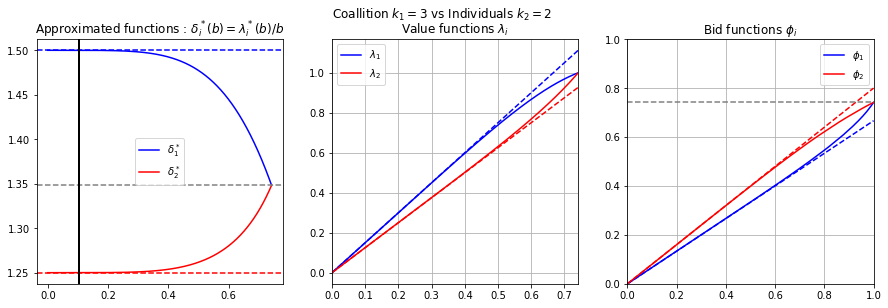

Nb of eval : 40
eps_star : 2.7072845742456405e-06
tstar : 0.637371003032356


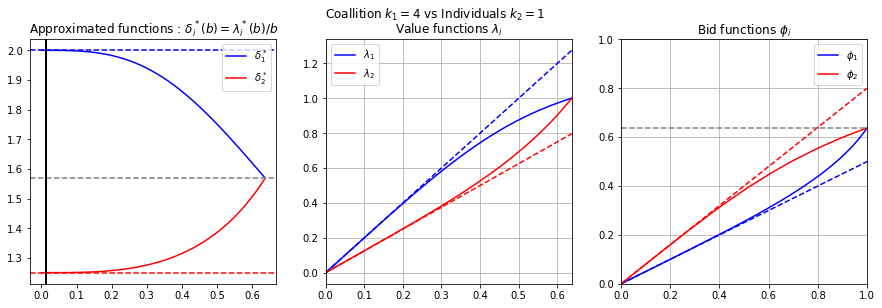

Nb of eval : 38
eps_star : 8.432842741626766e-06
tstar : 0.8411144309341715


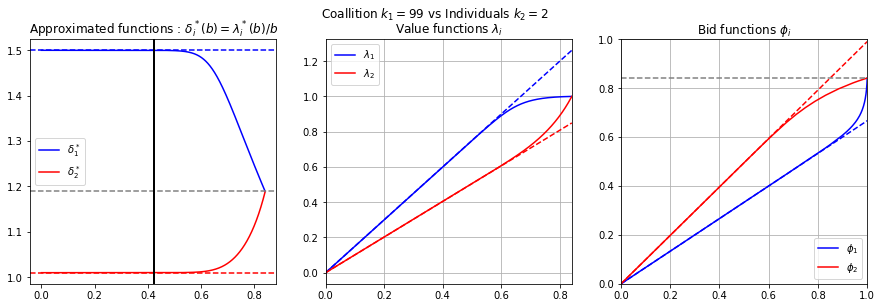

In [181]:
RV = stats.uniform()

for (k1,k2) in [(1,4),(2,3),(3,2),(4,1),(99,2)] :
    out = scenario1_iterate_CUSTOM(k1,k2,RV,RV,eps=10**-5,show_msg=True)
    print("tstar :",out['tstar'])
    display2(out)

----

## IID case, $k_1=1,F_1=F_2$

We can compare the results of our method with the close-form expression of the bid function :

$ v \mapsto v-\int_0^v \frac{F^{n-1}(y)}{F^{n-1}(v)} dy $

given the boudary value :

$ t_* = 1-\int_0^1 F^{n-1}(y)dy $

In [182]:
def scenario1_IID_shoot_from_close_form_boudary(k2,RV,N=10_000,correct=True) :
    tstar = 1-integrate.quad( lambda y:RV.cdf(y)**(k2) , 0, 1, limit=1000, epsabs=10**-10,epsrel=10**-10)[0]
    
    return scenario1_shoot(tstar,1,k2,RV,RV,N=N,correct=correct)

$F = \text{Beta}(2,1)=\text{Unif}[0,1]^2$

$\rightarrow$ the bid function should be linear

Warning f(0)=0


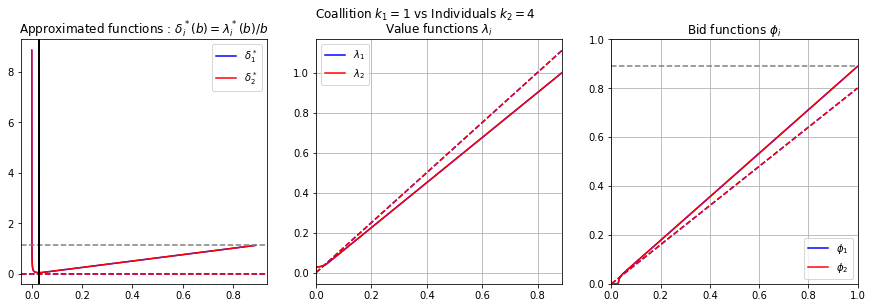

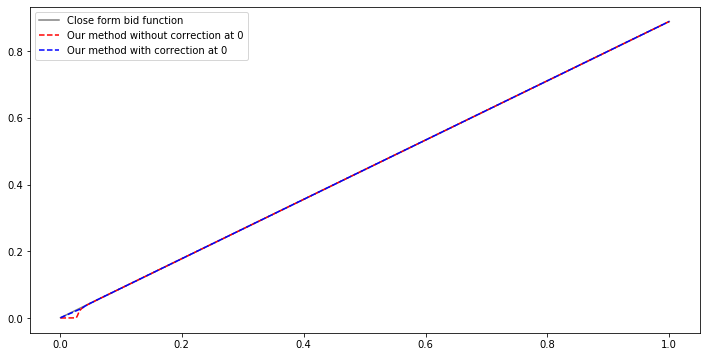

In [187]:
RV = stats.beta(a=2,b=1)
if(RV.pdf(0)  == 0) :
    print("Warning f(0)=0")

n=5

v_ = np.linspace(0.001,1,500)
br_ = [v-integrate.quad(lambda y:RV.cdf(y)**(n-1),0,v)[0]/(RV.cdf(v)**(n-1)) for v in v_]

out_cor = scenario1_IID_shoot_from_close_form_boudary(4,RV,correct=True,N=10_000)
out_nocor = scenario1_IID_shoot_from_close_form_boudary(4,RV,correct=False,N=10_000)

display2(out_nocor)

plt.figure(figsize=(12,6))
plt.plot(v_,br_,color='gray',label='Close form bid function')
plt.plot(v_,[bid1_f(v,out_nocor) for  v in v_],'r--',label='Our method without correction at 0')
plt.plot(v_,[bid1_f(v,out_cor) for  v in v_],'b--',label='Our method with correction at 0')
plt.legend()
plt.show()

$F = \text{Beta}(10,1)=\text{Unif}[0,1]^{10}$

$\rightarrow$ the bid function should be linear

Warning f(0)=0


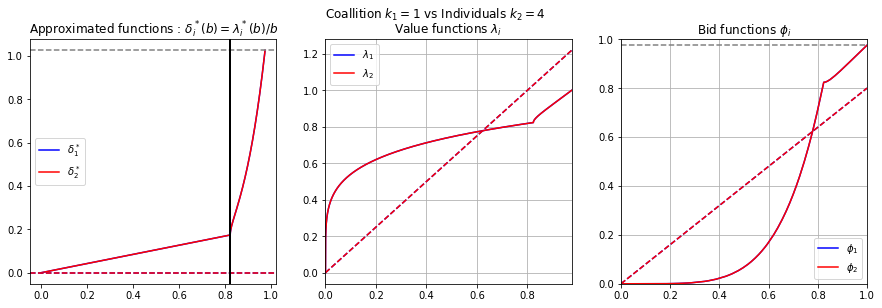

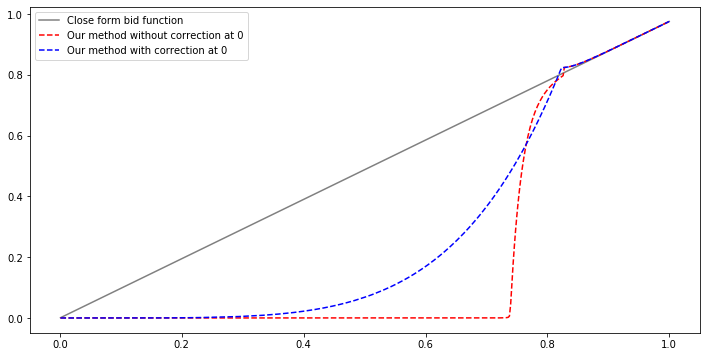

In [189]:
RV = stats.beta(a=1,b=10)
if(RV.pdf(0)  == 0) :
    print("Warning f(0)=0")

n=5

v_ = np.linspace(0.001,1,500)
br_ = [v-integrate.quad(lambda y:RV.cdf(y)**(n-1),0,v)[0]/(RV.cdf(v)**(n-1)) for v in v_]

out_cor = scenario1_IID_shoot_from_close_form_boudary(4,RV,correct=True,N=10_000)
out_nocor = scenario1_IID_shoot_from_close_form_boudary(4,RV,correct=False,N=10_000)

display2(out_cor)

plt.figure(figsize=(12,6))
plt.plot(v_,br_,color='gray',label='Close form bid function')
plt.plot(v_,[bid1_f(v,out_nocor) for  v in v_],'r--',label='Our method without correction at 0')
plt.plot(v_,[bid1_f(v,out_cor) for  v in v_],'b--',label='Our method with correction at 0')
plt.legend()
plt.show()

$F = \text{Beta}(1,2) \sim min(U_1,U_2)$ where $U_i$ is iid from $\text{Unif}[0,1]$

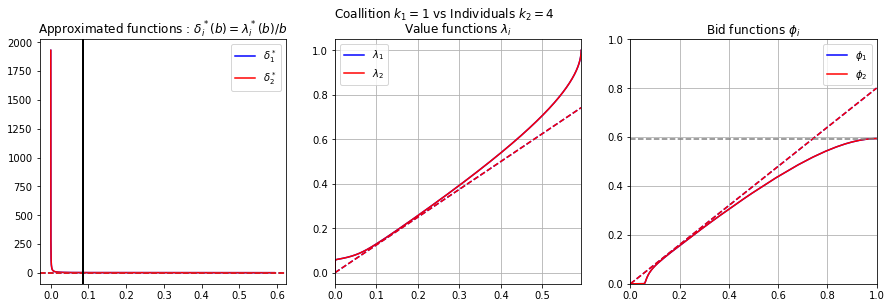

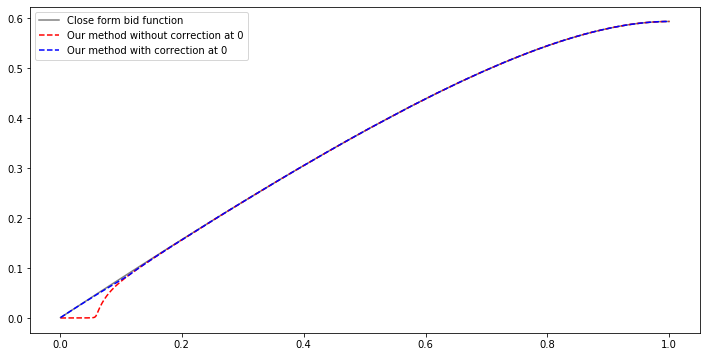

In [204]:
RV = stats.beta(a=1,b=2)
if(RV.pdf(0)  == 0) :
    print("Warning f(0)=0")

n=5

v_ = np.linspace(0.001,1,500)
br_ = [v-integrate.quad(lambda y:RV.cdf(y)**(n-1),0,v)[0]/(RV.cdf(v)**(n-1)) for v in v_]

out_cor = scenario1_IID_shoot_from_close_form_boudary(4,RV,correct=True,N=10_000)
out_nocor = scenario1_IID_shoot_from_close_form_boudary(4,RV,correct=False,N=10_000)

display2(out_nocor)

plt.figure(figsize=(12,6))
plt.plot(v_,br_,color='gray',label='Close form bid function')
plt.plot(v_,[bid1_f(v,out_nocor) for  v in v_],'r--',label='Our method without correction at 0')
plt.plot(v_,[bid1_f(v,out_cor) for  v in v_],'b--',label='Our method with correction at 0')
plt.legend()
plt.show()

$F = \text{Beta}(1,10) \sim \min(U_1,\dots,U_{10})$ where $U_i$ is iid from $\text{Unif}[0,1]$

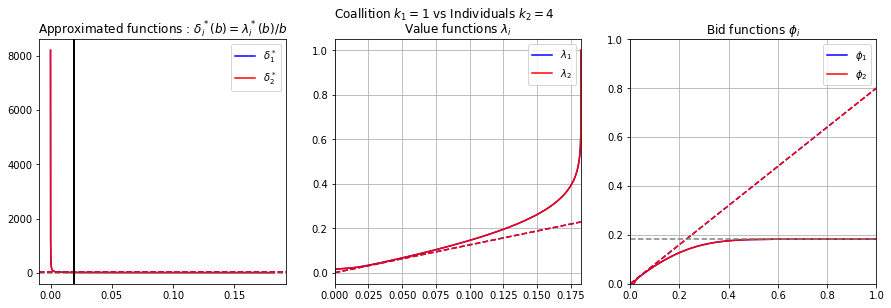

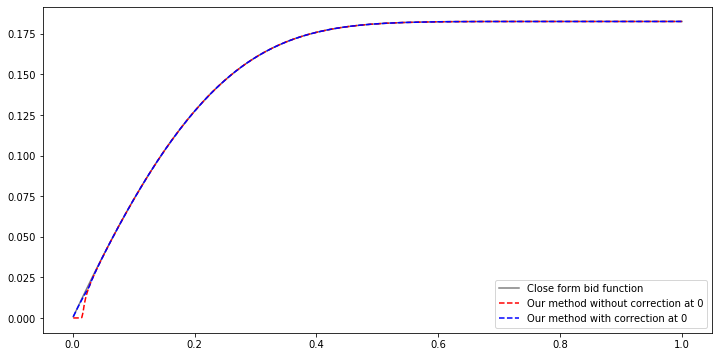

In [205]:
RV = stats.beta(a=1,b=10)
if(RV.pdf(0)  == 0) :
    print("Warning f(0)=0")

n=5

v_ = np.linspace(0.001,1,500)
br_ = [v-integrate.quad(lambda y:RV.cdf(y)**(n-1),0,v)[0]/(RV.cdf(v)**(n-1)) for v in v_]

out_cor = scenario1_IID_shoot_from_close_form_boudary(4,RV,correct=True,N=10_000)
out_nocor = scenario1_IID_shoot_from_close_form_boudary(4,RV,correct=False,N=10_000)

display2(out_nocor)

plt.figure(figsize=(12,6))
plt.plot(v_,br_,color='gray',label='Close form bid function')
plt.plot(v_,[bid1_f(v,out_nocor) for  v in v_],'r--',label='Our method without correction at 0')
plt.plot(v_,[bid1_f(v,out_cor) for  v in v_],'b--',label='Our method with correction at 0')
plt.legend()
plt.show()

### Iterative search of $t_*$

$F = \text{Beta}(1,2) \sim min(U_1,U_2)$ where $U_i$ is iid from $\text{Unif}[0,1]$

<font color=red> $\rightarrow$ Bad results </font>

Nb of eval : 2
eps_star : 0.0
Approximated tstar : 0.4
Close-form tstar : 0.5936507936507938


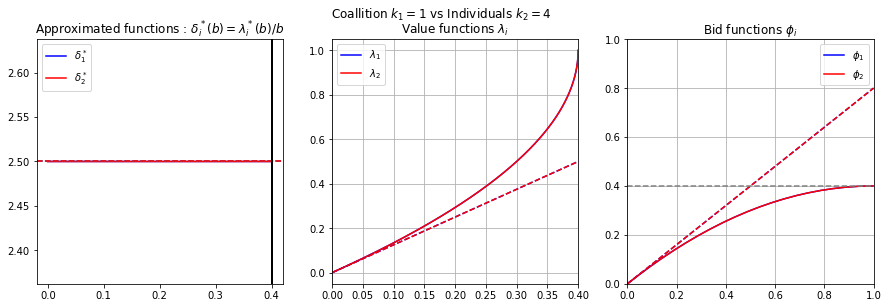

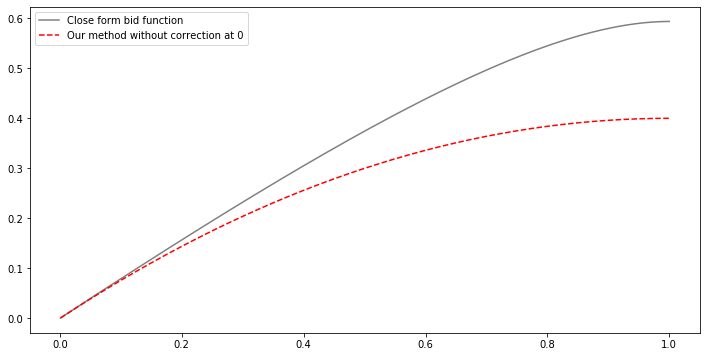

In [208]:
RV = stats.beta(a=1,b=2)
if(RV.pdf(0)  == 0) :
    print("Warning f(0)=0")

n=5

v_ = np.linspace(0.001,1,500)
br_ = [v-integrate.quad(lambda y:RV.cdf(y)**(n-1),0,v)[0]/(RV.cdf(v)**(n-1)) for v in v_]

out_cor = scenario1_iterate_CUSTOM(1,4,RV,RV,eps=10**-3,show_msg=True)
print("Approximated tstar : {}".format(out_cor['tstar']))
print("Close-form tstar : {}".format(br_[-1]))
display2(out_cor)

plt.figure(figsize=(12,6))
plt.plot(v_,br_,color='gray',label='Close form bid function')
plt.plot(v_,[bid1_f(v,out_cor) for  v in v_],'r--',label='Our method without correction at 0')
plt.legend()
plt.show()

## Non iid cases

Here we compare the mathematically equivalent situations :

- A **Coalition of 3** agents drawing their individual values from $\text{Unif}[0,1]$ vs **2 Individuals** drawing their individual values from $\text{Unif}[0,1]$
- **1 "strong" individual** drawing its value from $\text{Beta}(3,1)$ vs **2 Individuals** drawing their individual values from $\text{Unif}[0,1]$

First, we use the boundary value found by the method applied for the first formulation (using only uniform values) and use it as the starting point for the method applied for the second formulation

t_star (uni) : 0.7416970547499367
eps_star (uni) : 5.206141337279085e-09
eps_star (beta) : 0.002273560886635788


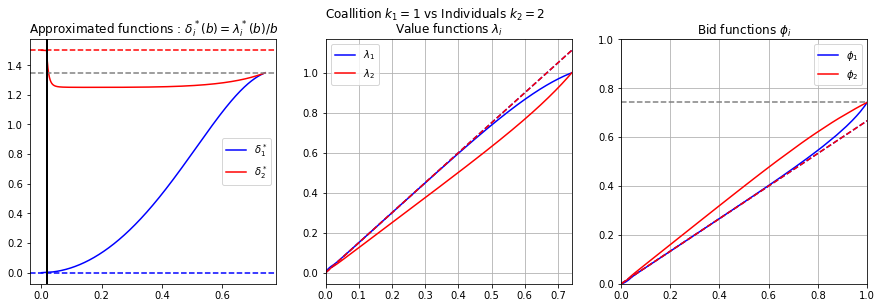

eps_star (kuma) : 0.04217186874790126


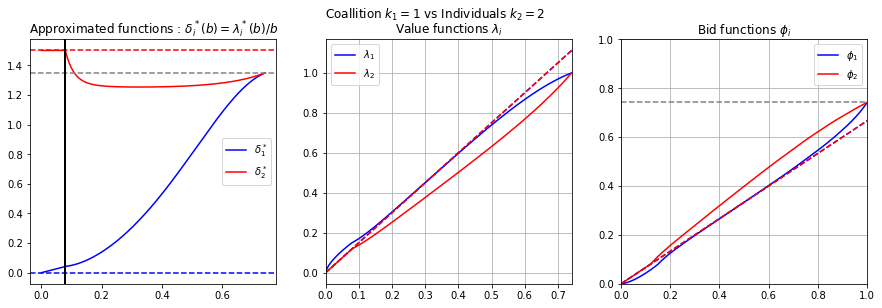

In [274]:
coal_size = 3
n = 5

RV_beta = stats.beta(a=coal_size,b=1)
RV_kuma = kumaraswamy(a=coal_size,b=1)
RV_uni = stats.uniform()

out_uni = scenario1_iterate_CUSTOM(coal_size,n-coal_size,RV_uni,RV_uni,eps=10**-8,show_msg=False)
oracle_tstar = out_uni['tstar']

print("t_star (uni) : {}".format(oracle_tstar))
print("eps_star (uni) : {}".format(out_uni['eps_star']))

out_beta = scenario1_shoot(oracle_tstar,1,n-coal_size,RV_beta,RV_uni)
print("eps_star (beta) : {}".format(out_beta['eps_star']))
display2(out_beta)

out_kuma = scenario1_shoot(oracle_tstar,1,n-coal_size,RV_kuma,RV_uni)
print("eps_star (kuma) : {}".format(out_kuma['eps_star']))
display2(out_kuma)

Next, we consider the 30 steps of the iterative algorithm that finds $t_*$ by minmizing $\epsilon_*$ for each implementation

Nb of eval : 30
eps_star : 0.00018082146957956678
Maximum number of evaluations reached
Elapsed time 30.588483095169067


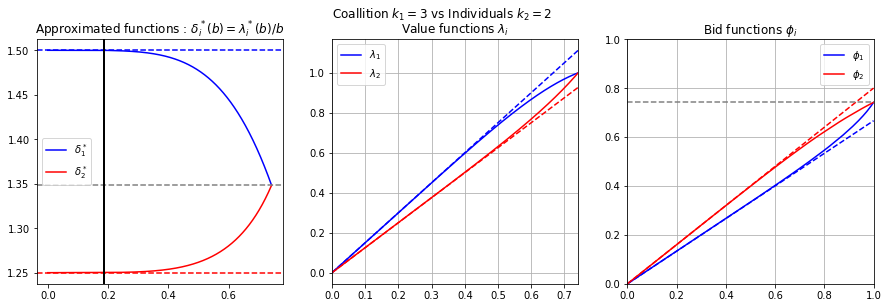

Nb of eval : 30
eps_star : 0.004021610868451865
Maximum number of evaluations reached
Elapsed time 57.79657506942749


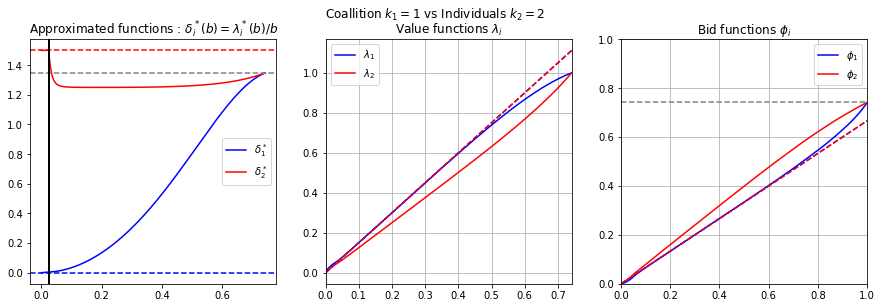

Nb of eval : 30
eps_star : 0.018611551914195442
Maximum number of evaluations reached
Elapsed time 51.06504988670349


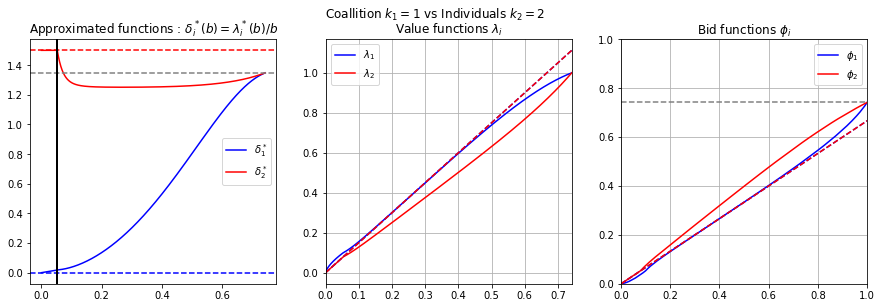

In [275]:
coal_size = 3
n = 5

RV_beta = stats.beta(a=coal_size,b=1)
RV_kuma = kumaraswamy(a=coal_size,b=1)
RV_uni = stats.uniform()

start = time.time()
out_ref = scenario1_iterate_CUSTOM(coal_size,n-coal_size,RV_uni,RV_uni,eps=0,nb_eval_max=30)
print("Elapsed time", time.time()-start)
display2(out_ref)

start = time.time()
out_beta = scenario1_iterate_CUSTOM(1,n-coal_size,RV_beta,RV_uni,eps=0,nb_eval_max=30)
print("Elapsed time", time.time()-start)
display2(out_beta)

start = time.time()
out_kuma = scenario1_iterate_CUSTOM(1,n-coal_size,RV_kuma,RV_uni,eps=0,nb_eval_max=30)
print("Elapsed time", time.time()-start)
display2(out_kuma)

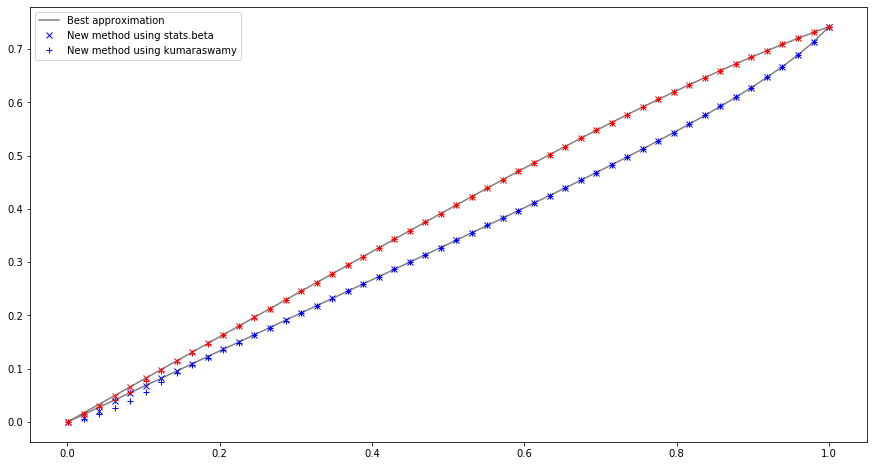

In [276]:
v_ = np.linspace(0.001,1,50)

plt.figure(figsize=(15,8))
plt.plot(v_,[bid1_f(v,out_ref) for  v in v_],color='gray',label='Best approximation')
plt.plot(v_,[bid1_f(v,out_beta) for  v in v_],'bx',label='New method using stats.beta')
plt.plot(v_,[bid1_f(v,out_kuma) for  v in v_],'b+',label='New method using kumaraswamy')
plt.plot(v_,[bid2_f(v,out_ref) for  v in v_],color='gray')
plt.plot(v_,[bid2_f(v,out_beta) for  v in v_],'rx')
plt.plot(v_,[bid2_f(v,out_kuma) for  v in v_],'r+')

plt.legend()
plt.show()

<font color=red> Problems with the second formulation : 
    
- even after several iterations, $\epsilon_*$ reaches a plateau which isn't satisfactory.
- takes more time
</font>

----

In [260]:
def scenario1_iterate_CUSTOM(k1,k2,RV_1,RV_2,eps=10**-5,nb_eval_max=500,N=10_000,show_msg=True) :
    l1_star = RV_1.pdf(0)*(1+1/k2)
    l2_star = RV_2.pdf(0)*(1+1/(k1+k2-1))
    
    a = 0#max(min(1/l1_star,1),0)  #warning if the support is changed
    b = 1#max(min(1/l2_star,1),0)
    
    tau = (np.sqrt(5)-1)/2
    
    x_1 = a + (1-tau)*(b-a)
    f_1 = scenario1_shoot(x_1,k1,k2,RV_1,RV_2,N,correct=True)
    
    x_2 = a + tau*(b-a)
    f_2 = scenario1_shoot(x_2,k1,k2,RV_1,RV_2,N,correct=True)
    
    i=2
    while(f_1['eps_star']>eps and f_2['eps_star']>eps and i < nb_eval_max) :
        if(f_1['eps_star'] > f_2['eps_star']) :
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau*(b-a)
            f_2 = scenario1_shoot(x_2,k1,k2,RV_1,RV_2,N,correct=True)
        else :
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1-tau)*(b-a)
            f_1 = scenario1_shoot(x_1,k1,k2,RV_1,RV_2,N,correct=True)
        i+=1
    
    if(show_msg) :
        print("Nb of eval :",i)
        print("eps_star :",min(f_1['eps_star'],f_2['eps_star']))
        if(i==nb_eval_max) :
            print("Maximum number of evaluations reached")
            
    if(f_1['eps_star']<f_2['eps_star']) :
        return f_1
    else :
        return f_2

### Appendix : Kumaraswamy distribution

In [244]:
import numpy as np
from scipy import stats

class kumaraswamy(stats.rv_continuous):
    def __init__(self, a=2, b=10):
        super().__init__()
        self._a = a
        self._b = b
        self._unif = stats.uniform(0, 1)

    def _pdf(self, x, **kwargs):
        a = self._a
        b = self._b
        return a * b * np.power(x, a - 1) * np.power((1 - np.power(x, a)), b - 1)

    def _cdf(self, x, **kwargs):
        a = self._a
        b = self._b
        return 1 - np.power((1 - np.power(x, a)), b)

    def _sf(self, x, **kwargs):
        return 1 - self.cdf(x)
    
    def _ppf(self,q, **kwargs) :
        return np.power(1-np.power(1-q,1/self._b),1/self._a)

    def _rvs(self):
        a = self._a
        b = self._b
        if self._size is None:
            u = self._unif.rvs()
        else:
            u = self._unif.rvs(self._size)
        return np.power(1 - np.power(1 - u, 1. / b), 1. / a)